In [38]:
#!/usr/bin/env python
# coding=utf-8

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math


from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func, and_

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import seaborn as sns
sns.set(color_codes=True)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    #fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [39]:
DIR = '../../data/data_evaluation_3MONTHS'
CDIR = '../../data/data_evaluation_3MONTHS/charts'

db = YTDatabase()

In [3]:
# get video infos

with db._session_scope(False) as session:

    df_videos = pa.read_sql(session.query(Video).statement, db.engine)

In [4]:
df_videos['dateAdded'] = df_videos['dateAdded'].apply(lambda x: datetime.strptime(x, date_format))
df_videos['crawlTimestamp'] = df_videos['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))

df_videos.head()

,id,channelID,title,description,category,dateAdded,tags,topicIds,attribution,duration,crawlTimestamp,deleted
0,__00T6BTcLk,UCVD-u8fo_n5EnUkKNrrjEGw,CS:GO - Clutch or Kick! #82,Submit a Demo for an upcoming Episode: http://...,20,2017-03-01 19:26:17,"[""clayman90"",""clayman"",""rechyyy"",""rech"",""cok"",...",[],None,PT3M18S,2017-03-02 00:13:34,None
1,__3DpIJilQI,UCeE3lj6pLX_gCd0Yvns517Q,Ozzy Man Reviews: Cricket Nut Shots,Me commentary on some of the most eye watering...,24,2017-01-10 07:00:30,"[""ozzy man reviews"",""ozzy"",""man"",""ozzie"",""ozzy...",[],None,PT1M54S,2017-01-11 00:09:08,True
2,__3e1lrV5c8,UCajyfb5EUPd3f3deUk0dBEQ,NEUE DM ZAHNBÜRSTEN PINSEL im LIVE TEST | Mami...,Neu bei dm gibt es die gehypten Zahnbürsten Pi...,26,2017-02-19 11:30:00,"[""mamiseelen"",""dm zahnb\u00fcrsten pinsel"",""li...","[""/m/0yxzwny"",""/m/012xff""]",None,PT7M41S,2017-02-20 00:10:55,None
3,__3Pz5Hmm4c,UCw6Ou-fRcPa23GvYq-VHEbA,IS LONZO BALL'S $495 SIGNATURE SHOE THE ZO2 WO...,ENJOY AND LEAVE A LIKE!\nPodcast Link - https:...,26,2017-05-06 04:12:59,"[""lonzo"",""ball"",""zo2"",""lonzo ball sneaker"",""bi...",[],None,PT11M16S,2017-05-07 00:12:42,None
4,__40p5sII08,UCOt4EtXTO6dDFSfcpAoWJIQ,ЭДВАРД РУКИ НОЖНИЦЫ. FTF 2017. Гомель,Фрагмент трансляции с Фри Тайм Фест. Гомель 2017,20,2017-04-03 10:00:11,"[""Anime"",""\u0424\u0422\u0424"",""FTF"",""2017"",""\u...",[],None,PT4M52S,2017-04-04 00:13:14,None


In [5]:
# duration calculation
import isodate

durations = []
for dt in df_videos['duration']:
    dur = isodate.parse_duration(dt)
    durations.append(dur.total_seconds())

df_duration = pa.DataFrame(durations)
print 'Sum:', df_duration.sum(),'seconds'
print 'Sum:', df_duration.sum()/3600,'std'
print df_duration.describe()


Sum: 0    280529577.0
dtype: float64 seconds
Sum: 0    77924.8825
dtype: float64 std
                   0
count  250420.000000
mean     1120.236311
std      2170.378819
min         1.000000
25%       279.000000
50%       596.000000
75%      1019.000000
max     86459.000000


In [40]:
with db._session_scope(False) as session:

    df_feature_videos = pa.read_sql(session.query(VideoFeatures.videoID, Video.duration).filter(and_(VideoFeatures.videoID==Video.id,  Video.category != 20)).statement, db.engine)

In [41]:
df_feature_videos.drop_duplicates(inplace=True)

In [42]:
durations_features = []
for dt in df_feature_videos['duration']:
    dur = isodate.parse_duration(dt)
    durations_features.append(dur.total_seconds())

df_durations_features = pa.DataFrame(durations_features)
print 'Sum:', df_durations_features.sum(),'seconds'
print 'Sum:', df_durations_features.sum()/3600,'std'
print df_durations_features.describe()

Sum: 0    75588164.0
dtype: float64 seconds
Sum: 0    20996.712222
dtype: float64 std
                   0
count  112093.000000
mean      674.334383
std      1359.598486
min         1.000000
25%       227.000000
50%       413.000000
75%       704.000000
max     86459.000000


<IPython.core.display.Javascript object>


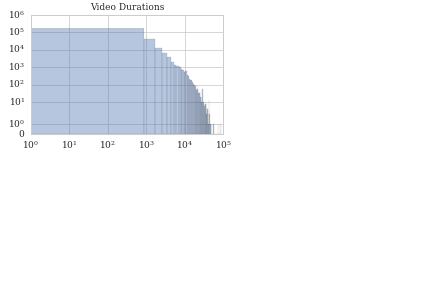

<IPython.core.display.Javascript object>


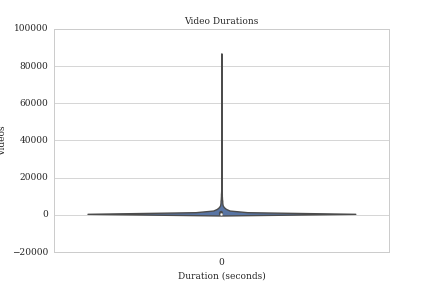

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


In [6]:
fig = plt.figure()
ax = sns.distplot(df_duration, kde=False, bins=100)
ax.set_xlabel('Duration (seconds)')
ax.set_ylabel('Videos')
ax.set_xscale('log')
ax.set_yscale('symlog')
#ax.legend()
plt.title('Video Durations')

save_plot('video_durations.pdf', fig, s_width, s_height)

fig = plt.figure()
ax = sns.violinplot(df_duration)
ax.set_xlabel('Duration (seconds)')
ax.set_ylabel('Videos')
#ax.set_xscale('log')
#ax.set_yscale('symlog')
#ax.legend()
plt.title('Video Durations')

<IPython.core.display.Javascript object>


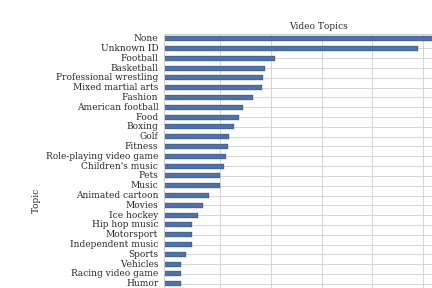

In [7]:
# Video topics distribution
topics = [x for x in csv.reader(open('../../data/'+'topics.txt','r'), delimiter='\t')]


topicIDs = []
topicTitles = {}
for t, tt in topics:
    topicIDs.append(t)
    topicTitles[t]=tt
            
topicIDs.append('/m/None')    
topicTitles['/m/None'] = 'None'

topicIDs.append('/m/NaT')    
topicTitles['/m/NaT'] = 'Unknown ID'

topiclist = []
for ct in df_videos['topicIds']:
    if len(json.loads(ct))==0:
        topiclist.append('/m/None')
    for t in json.loads(ct):
        if t in topicIDs: # Filter not supported topics (as of 2017, Freebase deprecated)
            topiclist.append(t)
        else:
            topiclist.append('/m/NaT')

df_topics = pa.DataFrame({ 'Topic' : [topicTitles[t] for t in topiclist]})

fig = plt.figure()
ax = df_topics['Topic'].value_counts().sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Videos')
ax.set_ylabel('Topic')
ax.set_xscale('symlog', linthreshx=10)
#ax.set_yscale('log')
#ax.legend()
plt.title('Video Topics')
fig.tight_layout()
save_plot('video_topics.pdf', fig, x_width, 1.4*x_height)

In [8]:
print len(df_videos)

print len(df_topics[df_topics.Topic!='None'])
df_topics['Topic'].value_counts()

250420
79203


None                       191814
Unknown ID                  78624
Football                      119
Basketball                     76
Professional wrestling         70
Mixed martial arts             67
Fashion                        45
American football              28
Food                           23
Boxing                         19
Golf                           15
Fitness                        14
Role-playing video game        13
Children's music               12
Music                          10
Pets                           10
Animated cartoon                8
Movies                          7
Ice hockey                      6
Hip hop music                   5
Motorsport                      5
Independent music               5
Sports                          4
Racing video game               3
Vehicles                        3
Humor                           3
Strategy video game             2
Cricket                         1
Entertainment                   1
Music of Latin

<IPython.core.display.Javascript object>


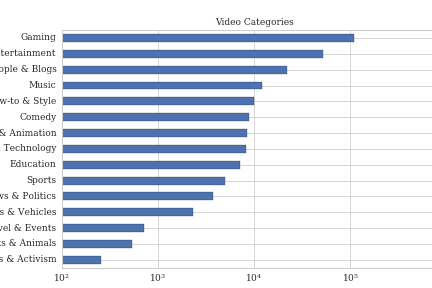

250420


Gaming                    109985
Entertainment              51698
People & Blogs             21904
Music                      12071
How-to & Style              9831
Comedy                      8801
Film & Animation            8420
Science & Technology        8192
Education                   7047
Sports                      4946
News & Politics             3724
Cars & Vehicles             2298
Travel & Events              705
Pets & Animals               538
Non-profits & Activism       254
Name: Category, dtype: int64

In [9]:
#categorys
categories = [x for x in csv.reader(open('../../data/'+'categories.txt','r'), delimiter='\t')]

catIDs = []
catTitles = {}
for t, tt in categories:
    #print t, tt
    catIDs.append(int(t))
    catTitles[int(t)]=tt
    
categorylist = []
for vt in df_videos['category']:
    if int(vt) in catIDs: # Filter not supported
        categorylist.append(int(vt))
        
df_cats = pa.DataFrame({ 'Category' : [catTitles[t] for t in categorylist]})
fig = plt.figure()
ax = df_cats['Category'].value_counts().sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Videos')
ax.set_ylabel('Category')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.legend()
plt.title('Video Categories')
#fig.tight_layout()
save_plot('video_Categories.pdf', fig, x_width, x_height)

print len(df_videos)

df_cats['Category'].value_counts()

In [10]:
channel_groups = df_videos.groupby(by='channelID')

In [11]:
counts = channel_groups['id'].count().sort_values(ascending=False)
print len(channel_groups)
counts.head()
counts.describe()

5891


count    5891.000000
mean       42.508912
std        69.225110
min         1.000000
25%         7.000000
50%        20.000000
75%        50.000000
max      1052.000000
Name: id, dtype: float64

In [12]:
df_videos['day_added'] = df_videos['dateAdded'].apply(lambda x: x.weekday())
df_videos['time_added'] = df_videos['dateAdded'].apply(lambda x: x.time())
df_videos['min_added'] = df_videos['dateAdded'].apply(lambda x: x.minute)
df_videos['hr_added'] = df_videos['dateAdded'].apply(lambda x: int(x.strftime('%H')))
df_videos['dayn'] = df_videos['dateAdded'].apply(lambda x: x.strftime("%A"))
df_videos.head()


,id,channelID,title,description,category,dateAdded,tags,topicIds,attribution,duration,crawlTimestamp,deleted,day_added,time_added,min_added,hr_added,dayn
0,__00T6BTcLk,UCVD-u8fo_n5EnUkKNrrjEGw,CS:GO - Clutch or Kick! #82,Submit a Demo for an upcoming Episode: http://...,20,2017-03-01 19:26:17,"[""clayman90"",""clayman"",""rechyyy"",""rech"",""cok"",...",[],None,PT3M18S,2017-03-02 00:13:34,None,2,19:26:17,26,19,Wednesday
1,__3DpIJilQI,UCeE3lj6pLX_gCd0Yvns517Q,Ozzy Man Reviews: Cricket Nut Shots,Me commentary on some of the most eye watering...,24,2017-01-10 07:00:30,"[""ozzy man reviews"",""ozzy"",""man"",""ozzie"",""ozzy...",[],None,PT1M54S,2017-01-11 00:09:08,True,1,07:00:30,0,7,Tuesday
2,__3e1lrV5c8,UCajyfb5EUPd3f3deUk0dBEQ,NEUE DM ZAHNBÜRSTEN PINSEL im LIVE TEST | Mami...,Neu bei dm gibt es die gehypten Zahnbürsten Pi...,26,2017-02-19 11:30:00,"[""mamiseelen"",""dm zahnb\u00fcrsten pinsel"",""li...","[""/m/0yxzwny"",""/m/012xff""]",None,PT7M41S,2017-02-20 00:10:55,None,6,11:30:00,30,11,Sunday
3,__3Pz5Hmm4c,UCw6Ou-fRcPa23GvYq-VHEbA,IS LONZO BALL'S $495 SIGNATURE SHOE THE ZO2 WO...,ENJOY AND LEAVE A LIKE!\nPodcast Link - https:...,26,2017-05-06 04:12:59,"[""lonzo"",""ball"",""zo2"",""lonzo ball sneaker"",""bi...",[],None,PT11M16S,2017-05-07 00:12:42,None,5,04:12:59,12,4,Saturday
4,__40p5sII08,UCOt4EtXTO6dDFSfcpAoWJIQ,ЭДВАРД РУКИ НОЖНИЦЫ. FTF 2017. Гомель,Фрагмент трансляции с Фри Тайм Фест. Гомель 2017,20,2017-04-03 10:00:11,"[""Anime"",""\u0424\u0422\u0424"",""FTF"",""2017"",""\u...",[],None,PT4M52S,2017-04-04 00:13:14,None,0,10:00:11,0,10,Monday


Int64Index([1, 4, 3, 2, 0, 5, 6], dtype='int64')


<IPython.core.display.Javascript object>


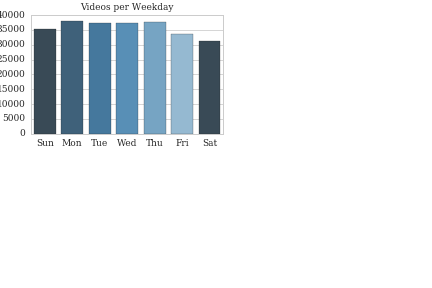

[u'0', u'1', u'2', u'3', u'4', u'5', u'6']


In [13]:
weekdays_dic ={-1.0:'',0.0:'Sun', 1.0:'Mon', 2.0:'Tue',3.0:'Wed',4.0:'Thu',5.0:'Fri',6.0:'Sat',7.0:''}

counts = df_videos['day_added'].value_counts()
print counts.index

fig = plt.figure()

#df_counts = pa.DataFrame(counts, index=[range(len(counts))])
ax = sns.barplot(x=counts.index, y=counts.values, palette=sns.color_palette("Blues_d"))
ax.set_xlabel('Weekday')
ax.set_ylabel('Videos')
ax.set_title('Videos per Weekday')

ax.set_xticklabels(ax.get_xticks())
labels = [item.get_text() for item in ax.get_xticklabels()]
print labels
ax.set_xticklabels([weekdays_dic[float(i)] for i in labels])

save_plot('video_uploads_weekdays.pdf', fig, s_width, s_height)

<IPython.core.display.Javascript object>


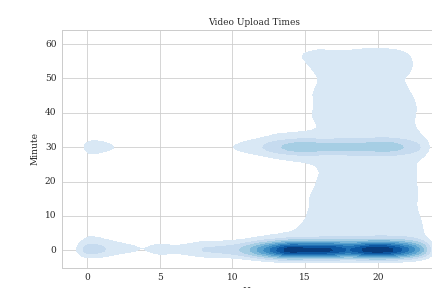

<IPython.core.display.Javascript object>


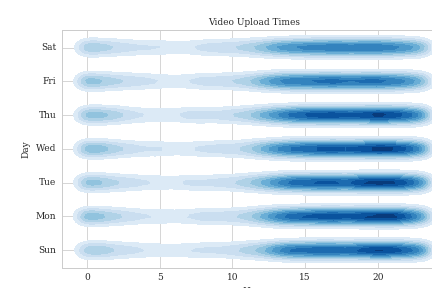

[u'-1.0', u'0.0', u'1.0', u'2.0', u'3.0', u'4.0', u'5.0', u'6.0', u'7.0']


In [14]:
#  plotting upload minutes to hours and day to hour


# scatter plot the points to see the dist? heatplot?
#g = sns.lmplot(x="hr_added", y="min_added", hue='day_added', data=group, fit_reg=False)
from scipy.stats import gaussian_kde

# Calculate the point density
x = df_videos['hr_added']
y = df_videos['min_added']
z = df_videos['day_added']

# Set up the figure
f, ax = plt.subplots()
ax.set_aspect("auto")

# Draw the two density plots
ax = sns.kdeplot(x, y, cmap="Blues", shade=True, shade_lowest=False)
ax.set_xlabel('Hour')
ax.set_ylabel('Minute')
plt.title('Video Upload Times')
save_plot('video_uploads_time_map.pdf', f, x_width, x_height)

weekdays_dic ={-1.0:'',0.0:'Sun', 1.0:'Mon', 2.0:'Tue',3.0:'Wed',4.0:'Thu',5.0:'Fri',6.0:'Sat',7.0:''}

# Set up the figure
f, ax = plt.subplots()
ax.set_aspect("auto")

# Draw the two density plots
ax = sns.kdeplot(x, z, cmap="Blues", shade=True, shade_lowest=False)
ax.set_xlabel('Hour')
ax.set_ylabel('Day')
ax.set_yticklabels(ax.get_yticks())
labels = [item.get_text() for item in ax.get_yticklabels()]
print labels
ax.set_yticklabels([weekdays_dic[float(i)] for i in labels])
plt.title('Video Upload Times')
save_plot('video_uploads_day_map.pdf', f, x_width, x_height)

<IPython.core.display.Javascript object>


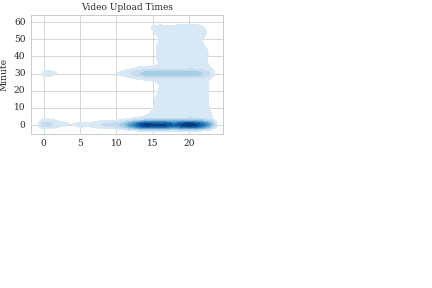

<IPython.core.display.Javascript object>


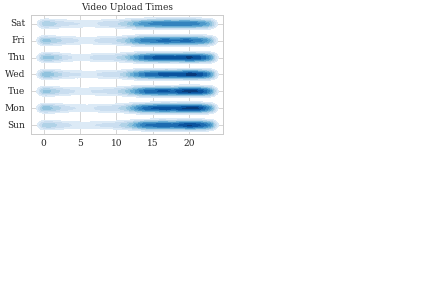

[u'-1.0', u'0.0', u'1.0', u'2.0', u'3.0', u'4.0', u'5.0', u'6.0', u'7.0']


In [15]:
# same but small


# scatter plot the points to see the dist? heatplot?
#g = sns.lmplot(x="hr_added", y="min_added", hue='day_added', data=group, fit_reg=False)
from scipy.stats import gaussian_kde

# Calculate the point density
x = df_videos['hr_added']
y = df_videos['min_added']
z = df_videos['day_added']

# Set up the figure
f, ax = plt.subplots()
ax.set_aspect("auto")

# Draw the two density plots
ax = sns.kdeplot(x, y, cmap="Blues", shade=True, shade_lowest=False)
ax.set_xlabel('Hour')
ax.set_ylabel('Minute')
plt.title('Video Upload Times')
save_plot('video_uploads_time_map_small.pdf', f, s_width, s_height)

weekdays_dic ={-1.0:'',0.0:'Sun', 1.0:'Mon', 2.0:'Tue',3.0:'Wed',4.0:'Thu',5.0:'Fri',6.0:'Sat',7.0:''}

# Set up the figure
f, ax = plt.subplots()
ax.set_aspect("auto")

# Draw the two density plots
ax = sns.kdeplot(x, z, cmap="Blues", shade=True, shade_lowest=False)
ax.set_xlabel('Hour')
ax.set_ylabel('Day')
ax.set_yticklabels(ax.get_yticks())
labels = [item.get_text() for item in ax.get_yticklabels()]
print labels
ax.set_yticklabels([weekdays_dic[float(i)] for i in labels])
plt.title('Video Upload Times')
save_plot('video_uploads_day_map_small.pdf', f, s_width, s_height)

<IPython.core.display.Javascript object>


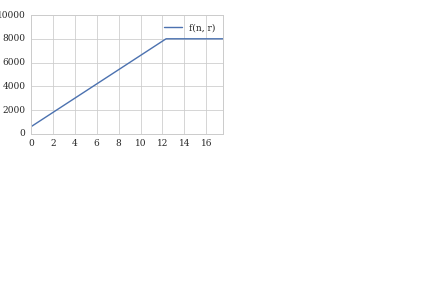

[(0, 600),
 (60, 610),
 (600, 700),
 (1800, 900),
 (3600, 1200),
 (7200, 1800),
 (43200, 7800),
 (86400, 8000)]

In [16]:
# frame extraction rate plot

min_frames = 600
max_frames = 8000

def index_spread(frames, duration):
    #print flength, stime
    num_frames = int(((1.0/6.0)* duration) + min_frames)
    if num_frames >= max_frames:
        num_frames = max_frames
    return (duration, num_frames)

#slength = int(frame_num / frame_rate)
#metricFn(frame_num, slength)

l = [index_spread(i, int(i/24)) for i in range(0, 63200*24, 100)]



dat = pa.DataFrame(l, columns=['time_s', 'sel_frames'])
dat['time_h'] = dat['time_s'].apply(lambda x: float(x)/60.0/60.0)
p = dat[['time_h', 'sel_frames']].plot.line(x='time_h', y='sel_frames')
p.set_ylim([0, 10000])
p.set_xlabel('Duration (hour)')
p.set_ylabel('Frames')
plt.legend(['f(n, r)'])
fig = p.get_figure()
save_plot('video_extraction_rate.pdf', fig, s_width, s_height)

d = [0, 60, 600, 1800, 3600, 7200, 43200, 86400]

dl = [index_spread(int(i*24), i) for i in d]
dl

